In [31]:
from physDBD import ImportHelper, DataDesc, Params0GaussTraj, RxnInputsGaussLayer, \
    DParams0GaussTraj, RxnGaussModel, TrainingGaussData, DataTypeGauss, Params0Gauss
import numpy as np
import tensorflow as tf
import sys
import os
import datetime
import pickle
import matplotlib.pyplot as plt

# Network

In [32]:
data_desc = DataDesc(
    seed_start_inc=0,
    seed_end_exc=25,
    time_start=1,
    time_end=100,
    time_interval=0.1,
    species=["H","P"]
)

In [33]:
# Shallow
'''
subnet = tf.keras.Sequential([
    tf.keras.layers.Dense(25, activation='relu', kernel_constraint=tf.keras.constraints.max_norm(1.)),
    tf.keras.layers.Dropout(0.5)
])
'''

"\nsubnet = tf.keras.Sequential([\n    tf.keras.layers.Dense(25, activation='relu', kernel_constraint=tf.keras.constraints.max_norm(1.)),\n    tf.keras.layers.Dropout(0.5)\n])\n"

In [34]:
# Deep
'''
subnet = tf.keras.Sequential([
    tf.keras.layers.Dense(100, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(100, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(100, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3)
])
'''

no_outputs = 5
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(no_outputs, activation=None)
])

## Training data

In [35]:
def get_inputs(params):
    return np.array([[x.mu_v[0], x.mu_v[1], x.chol_v[0,0], x.chol_v[1,0], x.chol_v[1,1]] for x in params])

def get_outputs(params):
    return np.array([[x.dmu_v[0], x.dmu_v[1], x.dchol_v[0,0], x.dchol_v[1,0], x.dchol_v[1,1]] for x in params])

def get_inputs_outputs(params0_traj, dparams0_traj, idxs):
    train_params_inputs = [params0_traj[idx] for idx in idxs]
    train_inputs = get_inputs(train_params_inputs)

    train_params_outputs = [dparams0_traj[idx] for idx in idxs]
    train_outputs = get_outputs(train_params_outputs)
    return [train_inputs, train_outputs]


In [36]:
# Import
params0_norm_filtered_traj = Params0GaussTraj.fromFile("cache/cache_params_norm_filtered.txt", nv=2)
params0_norm_deriv_norm_traj = DParams0GaussTraj.fromFile("cache/cache_params_norm_deriv_norm.txt", nv=2)

nt_train_valid = int(0.5*params0_norm_deriv_norm_traj.nt)

idxs_all = np.arange(0,nt_train_valid)
np.random.shuffle(idxs_all)
frac_train = 0.8
nt_train = int(frac_train * nt_train_valid)
idxs_train = idxs_all[:nt_train]
idxs_valid = idxs_all[nt_train:]
idxs_test = np.arange(nt_train_valid,params0_norm_deriv_norm_traj.nt)

train_inputs, train_outputs = get_inputs_outputs(params0_norm_filtered_traj.params0_traj, params0_norm_deriv_norm_traj.dparams0_traj, idxs_train)
valid_inputs, valid_outputs = get_inputs_outputs(params0_norm_filtered_traj.params0_traj, params0_norm_deriv_norm_traj.dparams0_traj, idxs_valid)
test_inputs, test_outputs = get_inputs_outputs(params0_norm_filtered_traj.params0_traj, params0_norm_deriv_norm_traj.dparams0_traj, idxs_test)


In [37]:
print(train_inputs.shape)
print(valid_inputs.shape)
print(test_inputs.shape)

(395, 5)
(99, 5)
(495, 5)


# Train

In [38]:
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss=loss_fn,
              run_eagerly=False)

# Log outputs for tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, 
    histogram_freq=1,
    write_graph=False
    )

# Write weights of lowest validation score
val_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'trained/weights_lowest_val', 
    monitor='val_loss', 
    verbose=1,
    save_best_only=True, 
    save_weights_only=True,
    mode='auto', 
    save_frequency=1
    )

# Train!
model.fit(
    train_inputs, 
    train_outputs, 
    validation_data=(valid_inputs,valid_outputs),
    epochs=500, 
    callbacks=[tensorboard_callback,val_checkpoint],
    # callbacks=[tensorboard_callback],
    batch_size=64
)

# Save
model.save("trained/trained_final", save_traces=False)

Epoch 1/500
7/7 [==============================] - 0s 17ms/step - loss: 2.0799 - val_loss: 2.1588

Epoch 00001: val_loss improved from inf to 2.15881, saving model to trained/weights_lowest_val
Epoch 2/500
7/7 [==============================] - 0s 3ms/step - loss: 1.8155 - val_loss: 1.9123

Epoch 00002: val_loss improved from 2.15881 to 1.91226, saving model to trained/weights_lowest_val
Epoch 3/500
7/7 [==============================] - 0s 3ms/step - loss: 1.6281 - val_loss: 1.7021

Epoch 00003: val_loss improved from 1.91226 to 1.70213, saving model to trained/weights_lowest_val
Epoch 4/500
7/7 [==============================] - 0s 3ms/step - loss: 1.4594 - val_loss: 1.5255

Epoch 00004: val_loss improved from 1.70213 to 1.52547, saving model to trained/weights_lowest_val
Epoch 5/500
7/7 [==============================] - 0s 3ms/step - loss: 1.3137 - val_loss: 1.3649

Epoch 00005: val_loss improved from 1.52547 to 1.36494, saving model to trained/weights_lowest_val
Epoch 6/500
7/7 [=

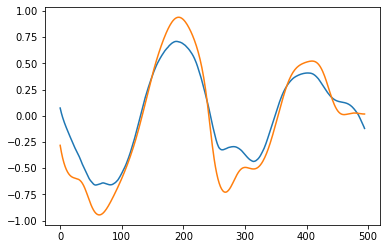

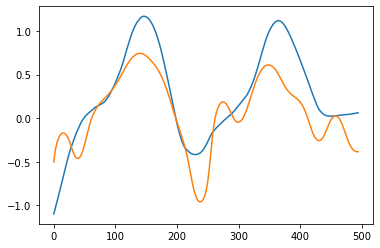

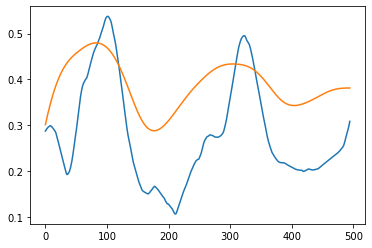

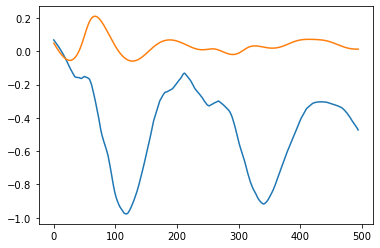

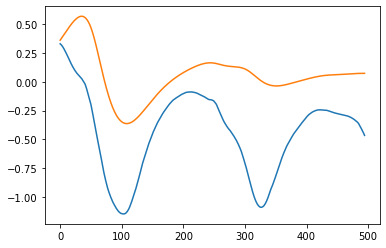

In [39]:
test_outputs_check = model(test_inputs).numpy()

for i in range(0,5):
    plt.figure()
    plt.plot(test_outputs_check[:,i])
    plt.plot(test_outputs[:,i])